In [1]:
import numpy as np
import pandas as pd
import itertools as it

import matplotlib.pyplot as plt

from scipy import stats

from PIL import Image, ImageEnhance
import imageio
import scipy.ndimage as spimg
import skimage as skimg
from skimage.segmentation import slic

In [2]:
%config Completer.use_jedi = False

## HexArray

In [3]:
myhex = np.zeros((12,12)) 

In [4]:
myhex[0:1,3:9] = 1
myhex[1:3,2:10] = 1
myhex[3:5,1:11] = 1
myhex[5:7,:12] = 1
myhex[7:9,1:11] = 1
myhex[9:11,2:10] = 1
myhex[11:12,3:9] = 1

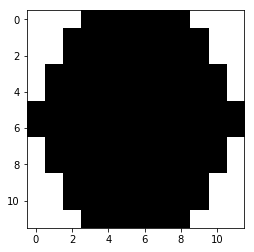

In [5]:
plt.imshow(myhex, cmap='binary');

In [6]:
hex_array = np.ones((222,399), dtype=int)*255
hex_coords = pd.DataFrame(0,index=pd.MultiIndex.from_product([range(1,45), range(1,19)], names=['X','Y']),columns=['hex_xstart','hex_ystart','center_start'])

In [7]:
def make_low_res(arr, background=255):
    def run_through_2d(channel):
        hex_array = np.ones((222,399), dtype=int)*background
        for y, x in it.product(range(1,19),range(1,45)):
            xstart = int(6*(x-1)*1.5) # please don't ask me how I figured this equation out, it works
            ystart = (y-1)*12
            if x % 2 == 0:  
                ystart = ystart + 6

            hex_coords.loc[(x,y),'hex_xstart'] = xstart
            hex_coords.loc[(x,y),'hex_ystart'] = ystart
            hex_coords.loc[(x,y),'center_xstart'] = xstart + 5
            hex_coords.loc[(x,y),'center_ystart'] = ystart + 5

            yend = ystart + 12
            xend = xstart + 12

            # val should be adjusted depending on what is to be plotted
            val = int(channel[ystart:yend,xstart:xend].mean())
            
            current_hex = hex_array[ystart:yend,xstart:xend]
            hex_array[ystart:yend,xstart:xend] = np.where(myhex, val, current_hex)
        return hex_array

    shape = arr.shape
    
    if len(shape) == 2:
        new_arr = run_through_2d(arr)
        return new_arr
    elif len(shape) == 3:
        numchan = arr.shape[-1]
        lowres_list = list()
        for channel_num in range(numchan):
            channel = arr[:,:,channel_num]
            new_channel = run_through_2d(channel)
            lowres_list.append(new_channel)
        new_arr = np.stack(lowres_list,axis=2)
        return new_arr
    else:
        print('Only arrays of 2 or 3 dimensions supported.')
        return

## Importing and Fixing up Liver Image

### L10C

In [8]:
tissue = 'L10C'

In [9]:
liver_origI = Image.open('/myvol/data2/pics/%s.cropped.isolated.sat.seg.tif' % tissue).convert('RGB')
liver_origA = np.array(liver_origI)

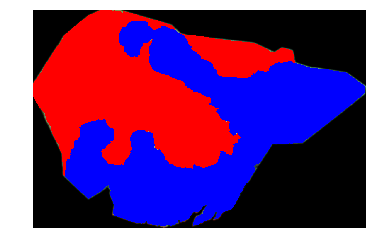

In [10]:
plt.imshow(liver_origA);
plt.axis('off');

In [11]:
hex_shape = hex_array.shape
hex_shape

(222, 399)

In [12]:
liver_shape = liver_origA.shape
liver_shape

(744, 1136, 3)

Liver needs to be resized (with the same aspect ratio). First, confirm which dimension to shrink by and then use the `thumbnail()` function to shrink.

In [13]:
print(int((hex_shape[0]/liver_shape[0])*liver_shape[1]) < liver_shape[1])

True


Shrink using second axis.

In [14]:
liver_origI.thumbnail((1e6, hex_shape[0]))

In [15]:
liver_origA = np.array(liver_origI)

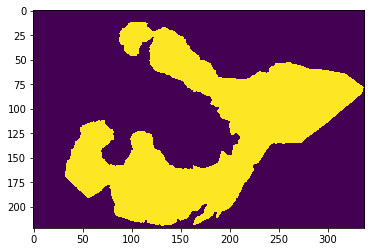

In [16]:
plt.imshow(liver_origA[:,:,2] == 255);
# plt.axis('off');

And now pad to get to actual size of the array and then center:

In [17]:
pad_length = int((hex_array.shape[1] - liver_origA.shape[1])/2)
liver_origA = np.pad(liver_origA, ((0,0), (pad_length, pad_length), (0,0)), mode='constant', constant_values=0)

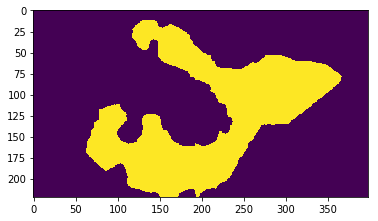

In [18]:
selem = skimg.morphology.disk(5)
plt.imshow(skimg.morphology.closing(liver_origA[:,:,2] == 255, selem=selem));

In [19]:
binary = liver_origA[:,:,2] == 255

## Segmentation

In [22]:
def segment(array_input, method='median', n_segments=400, compactness=10, channels=range(3)):
    liverA_seg = slic(array_input, n_segments=n_segments, compactness=compactness) #400, 10
    segs = np.arange(liverA_seg.flatten().max()+1)
    
    if method == 'median':
        valfun = lambda x: np.median(x).astype(np.uint8)

    elif method == 'mean':
        valfun = lambda x: x.mean(dtype=np.uint8)

    elif method == 'mode':
        valfun = lambda x: stats.mode(x).mode[0]

    elif method == 'min':
        valfun = lambda x: x.min().astype(np.uint8)
        
    elif method == 'mean_mid50':
        def valfun(x):
            length = len(x)
            return np.sort(x)[int(length/4):int((3/4)*length)].mean(dtype=np.uint8)
        
    liverA_seg_color = list()
    for chan in channels:
        liverA_seg_chan = liverA_seg.copy()
        for i in segs:
            pixel_vals = array_input[:,:,chan][liverA_seg_chan == i]
            
            val = valfun(pixel_vals)
            
            liverA_seg_chan = np.where(liverA_seg_chan == i, val, liverA_seg_chan)
        liverA_seg_color.append(liverA_seg_chan)
    
    if len(channels) > 1:
        liverA_seg_color = np.stack(liverA_seg_color, axis=2)
        if len(channels) == 2:
            # won't be able to imshow an array with only 2 channels, need to make a 3rd channel with zero
            liverA_seg_color = np.concatenate([liverA_seg_color, np.zeros((liverA_seg_color.shape[0],
                                                                           liverA_seg_color.shape[1],
                                                                           1))], axis=2).astype(np.uint8)
    else:
        liverA_seg_color = liverA_seg_color[0]
    liverA_seg_color = liverA_seg_color.astype(np.uint8)


    random_segs = segs.copy()
    np.random.shuffle(random_segs)
    liverA_seg_rand = liverA_seg.copy()
    for i, j in zip(segs, random_segs):
        liverA_seg_rand = np.where(liverA_seg_rand == i, j, liverA_seg_rand)
    return liverA_seg_rand, liverA_seg_color

In [23]:
# array_input = spimg.rotate(liver_origA,180)
array_input = liver_origA

In [24]:
liverA_seg_rand, liverA_seg_color = segment(array_input, n_segments=50, compactness=20)

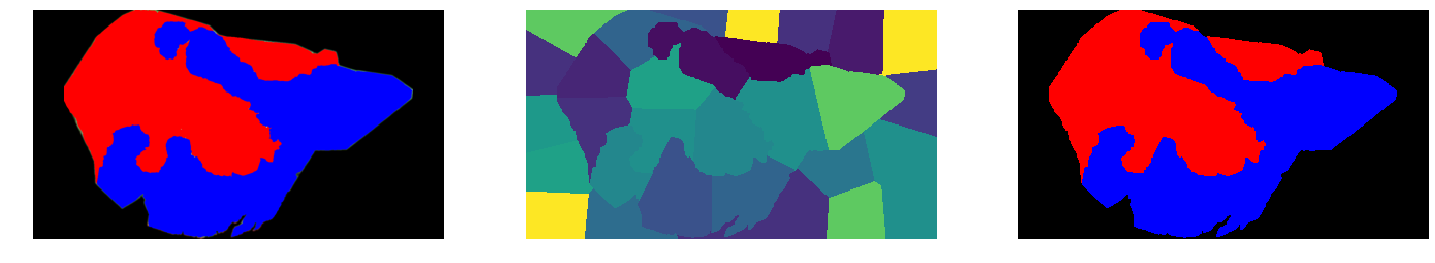

In [25]:
fig, axes = plt.subplots(1,3,figsize=(25,5))

axes[0].imshow(array_input);
axes[0].axis('off');

axes[1].imshow(liverA_seg_rand);
axes[1].axis('off');

axes[2].imshow(liverA_seg_color);
axes[2].axis('off');

Export to a png for manipulation in Fiji/ImageJ.

In [303]:
imageio.imwrite('/myvol/data2/pics/%s.sat.tissue.only.seg.png' % tissue, liverA_seg_color)